In [116]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import platform
from sklearn import preprocessing
from scipy.stats import ttest_ind
from scipy.stats import linregress
from event_utils import get_events
from create_stim_table import create_stim_df
import matplotlib.pyplot as plt
%matplotlib inline

# This patch of code just ensures we get an easy to read font size for the duration of the notebook
import matplotlib
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [2]:
# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

In [3]:
def find_divide_indices(stim_table):
    '''
    Finds the indices where each new stimulus presentation after the first presentation
    starts.
    
    Returns:
        List of indices representing the start of the next stimulus
    '''
    # Find the indices where each new stimulus presentation after the first presentation starts
    divide_indices = []

    for i in range(min(stim_table.index), max(stim_table.index)):
        try:
            if stim_table.start[i+1]-stim_table.end[i] > 100:
                divide_indices.append(i) # saves index where new stim presentation begins
        except:
            pass
    return divide_indices

In [4]:
def divide_stim_table(stim_table, divide_indices=[]):
    '''
    Divides input stimulus table based on indices corresponding to separate stimulus
    presentations.
    If there were 3 presentations, three dataframes for each presentation are returned. 
    If there were 2 presentations, three dataframes for each presentation are still 
    returned with the third being null.
    
    Returns:
        3 divided stimulus tables corresponding to first, second, and third or null stimulus
        presentation start. 
    '''
    if len(divide_indices)==2: # 3 presentations 
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:divide_indices[1]], stim_table.loc[divide_indices[1]+1:]
    elif len(divide_indices) == 1: # 2 presentations
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:], pd.DataFrame()
    else:
        raise Exception("Stimulis has only one presentation. Nothing to divide.")

In [21]:
def generate_response_matrices(stim_table, all_events):
    '''
    This function generates response matrices given an input stimulus table. 
    Stimulus table can be divided based on stimulus presentations, or undivided.
    
    Returns:
        orientation_matrix: 1D array with orientation value for each frame
        frequency_matrix: 1D array with frequency value for each frame
        response: matrix of shape (# cells, # stimuli, 60) with response of each
            cell to each stimulus over its presentation period of 60 frames 
    '''
    stim_table = stim_table.reset_index(drop=True)
    if stim_table.stim_category[0] == "drifting_gratings": # need to split stim ID
        # generate response matrix
        response = np.empty((len(all_events.index), len(stim_table), 60)) # 3d array for responses at each frame to each stimulus for each neuron
        for i in range(len(stim_table)):
            for cell_index in range(len(all_events.index)):
                response[cell_index,i,:] = all_events.iloc[cell_index, stim_table.start[i]:stim_table.start[i]+60]
        return response
    elif stim_table.stim_category[0] == "static_gratings" or stim_table.stim_category[0] == "natural_scenes":
        # generate response matrix
        response = np.empty((len(all_events.index), len(stim_table), 7)) # 3d array for responses at each frame to each stimulus for each neuron
        stim_table = stim_table.reset_index(drop=True)
        for i in range(len(stim_table)):
            for cell_index in range(len(all_events.index)):
                response[cell_index,i,:] = all_events.iloc[cell_index, stim_table.start[i]:stim_table.start[i]+7]
        return response
    
    
# OLD: natural scenes stimulus matrix
#         stimulus_matrix = np.zeros(len(stim_table))
#         null = np.zeros(1)
#         # Loop through each stimulus presentation, store its parameters
#         for i in range(len(stim_table)):
#             # extract orientation and temporal frequency info by splitting stimulus ID
#             stimulus_matrix[i] = stim_table.stim_id[i]

In [6]:
def responses_per_stimulus(stim_table, response_matrix):
    responses_by_stimulus = pd.DataFrame(columns=["stim_id","response_matrix"])
    
    for stim_id in np.unique(stim_table.stim_id):
        temp_stim_id_df = stim_table[stim_table.stim_id==stim_id]
        # below we are indexing the responses in the response matrix corresponding to the target 
        # stim ID values. The indices of target stim ID may be greater than the response matrix 
        # size since we devided the stimulus tables based on when the presentation was shown.
        # So we subtract the indices of each target stim ID by the first index of the stim table, 
        # to normalize the values.
        response_stimulus_matrix = response_matrix[:,list(temp_stim_id_df.index-stim_table.index[0]),:]
        responses_by_stimulus.loc[len(responses_by_stimulus)] = [stim_id, response_stimulus_matrix]
    
    return responses_by_stimulus

In [7]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

# Create data cache object 
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [14]:
# Select the relevant data for chosen container ID
desired_container_id = 688678764
desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first

# Get session IDs for each session
session_one_id = desired_container[0]["id"]

# load in session data for each session
session_one = boc.get_ophys_experiment_data(ophys_experiment_id=session_one_id)

# Get all event traces for all neurons in given session 
all_events = get_events(boc, session_one_id, "VISp")

# Get full stimulus table for a given session
stim_table = create_stim_df(boc, session_one_id)

In [15]:
# Drifting gratings, session 1

In [16]:
drifting_gratings_table = stim_table[stim_table.stim_category == "drifting_gratings"]

In [17]:
divide_indices = find_divide_indices(drifting_gratings_table)

In [18]:
dg1, dg2, dg3 = divide_stim_table(drifting_gratings_table, divide_indices)

In [22]:
response1 = generate_response_matrices(dg1, all_events)
response2 = generate_response_matrices(dg2, all_events)
response3 = generate_response_matrices(dg3, all_events)

In [ ]:
# Calculate mean responses 

In [23]:
mean1 = np.nanmean(response1)
mean2 = np.nanmean(response2)
mean3 = np.nanmean(response3)

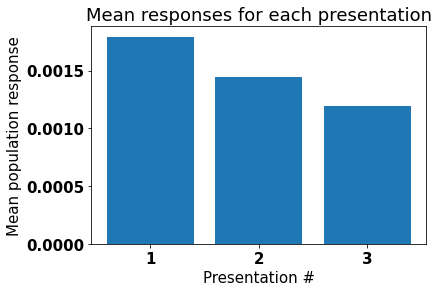

In [24]:
plt.bar([1,2,3],[mean1, mean2, mean3])
plt.title("Mean responses for each presentation")
plt.xticks([1,2,3])
plt.ylabel("Mean population response")
plt.xlabel("Presentation #")
plt.show()

In [120]:
# Fit a linear regression model
slope, intercept, r_value, p_value, std_err = linregress(range(len([mean1, mean2, mean3])), [mean1, mean2, mean3])

# Check if the slope is negative (indicating a decreasing trend) and if the p-value is below a significance level (e.g., 0.05)
if slope < 0 and p_value < 0.05:
    print("The decreasing trend is statistically significant.")
else:
    print(f"The trend is not statistically significant. p-value = {p_value}")

The trend is not statistically significant. p-value = 0.7438312466066423


In [ ]:
# Mean responses for each presentation for each stimulus

In [74]:
# Create dataframe with response matrix for each stimulus ID
dg1_responses_by_stimulus = responses_per_stimulus(dg1, response1)
dg2_responses_by_stimulus = responses_per_stimulus(dg2, response2)
dg3_responses_by_stimulus = responses_per_stimulus(dg3, response3)

# Merge dataframes
responses_by_stimulus = pd.merge(dg1_responses_by_stimulus, dg2_responses_by_stimulus, on="stim_id", how="outer")
responses_by_stimulus = pd.merge(responses_by_stimulus, dg3_responses_by_stimulus, on="stim_id", how="outer")
responses_by_stimulus = responses_by_stimulus.rename(columns={"response_matrix_x": "response_matrix1", "response_matrix_y": "response_matrix2", "response_matrix": "response_matrix3"})

In [75]:
# Calculate mean responses for each stimulus
means = pd.DataFrame(columns=["stim_id", "mean1", "mean2", "mean3"])

index=0
for stim_id in np.unique(responses_by_stimulus.stim_id):
    matrix1 = responses_by_stimulus[responses_by_stimulus.stim_id==stim_id].response_matrix1[index]
    matrix2 = responses_by_stimulus[responses_by_stimulus.stim_id==stim_id].response_matrix2[index]
    matrix3 = responses_by_stimulus[responses_by_stimulus.stim_id==stim_id].response_matrix3[index]

    mean1 = np.nanmean(matrix1)
    mean2 = np.nanmean(matrix2)
    mean3 = np.nanmean(matrix3)

    means.loc[len(means)] = [stim_id, mean1, mean2, mean3]
    index+=1

<ipython-input-75-86fcbe10f800>:12: RuntimeWarning: Mean of empty slice
  mean3 = np.nanmean(matrix3)


In [76]:
heatmap_array_dg = np.asarray((list(means.mean1), list(means.mean2), list(means.mean3)))
#norm_heatmap_array_dg = preprocessing.normalize(heatmap_array_dg[~np.isnan(heatmap_array_dg)])

In [77]:
heatmap_array_dg

array([[0.00315901, 0.00119374, 0.00434736, 0.00101027, 0.00197837,
        0.00165346, 0.00133248, 0.00061189, 0.00135285, 0.00062131,
        0.00207189, 0.00161682, 0.00126812, 0.00184173, 0.00151294,
        0.00153717, 0.00194067, 0.00241871, 0.00214527, 0.00212757,
        0.00240031, 0.0010802 , 0.0027282 , 0.00259581, 0.00191515,
        0.00260945, 0.00074152, 0.0010883 , 0.00116312, 0.0013261 ,
        0.00236591, 0.00104152, 0.0014267 , 0.00314102, 0.00183404,
        0.0027221 , 0.00146719, 0.00269314, 0.00177168, 0.00172367,
        0.00150495],
       [0.00207001, 0.00131353, 0.00215566, 0.00213734, 0.00119831,
        0.00078572, 0.00079481, 0.0013106 , 0.00067423, 0.00058209,
        0.00169839, 0.00132817, 0.00157038, 0.00129611, 0.00116918,
        0.00229219, 0.00101511, 0.00246441, 0.00176302, 0.00152584,
        0.00338823, 0.00098017, 0.00123904, 0.0010252 , 0.00126218,
        0.00094066, 0.0012735 , 0.00089193, 0.00101809, 0.00057627,
        0.00218132, 0.00096

In [78]:
heatmap_array_dg.shape

(3, 41)

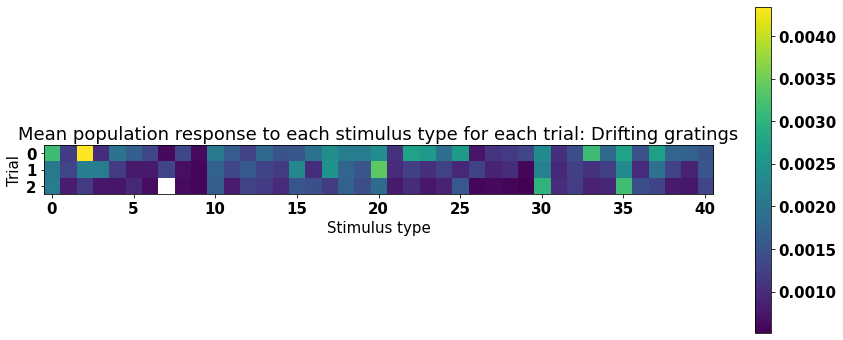

In [79]:
fig, ax = plt.subplots(figsize = (15,6))
im = ax.imshow(heatmap_array_dg)
fig.colorbar(im, ax=ax)
ax.set_yticks([0,1,2])
ax.set_ylabel("Trial")
ax.set_xlabel("Stimulus type")
ax.set_title("Mean population response to each stimulus type for each trial: Drifting gratings")
plt.show()

# Drifting gratings stimuli are sometimes shown more times in a session than other sessions

In [ ]:
fig, ax = plt.subplots(figsize = (15,6))
im = ax.imshow(norm_heatmap_array_dg)
fig.colorbar(im, ax=ax)
ax.set_yticks([0,1,2])
ax.set_ylabel("Trial")
ax.set_xlabel("Stimulus type")
ax.set_title("Normalized mean population response to each stimulus type for each trial: \nDrifting gratings")
plt.show()

# Drifting gratings stimuli are sometimes shown more times in a session than other sessions

In [23]:
# Static gratings, session 2 

In [80]:
# Get session IDs for each session
session_two_id = desired_container[1]["id"]

# load in session data for each session
session_two = boc.get_ophys_experiment_data(ophys_experiment_id=session_two_id)

# Get all event traces for all neurons in given session 
all_events = get_events(boc, session_two_id, "VISp")

# Get full stimulus table for a given session
stim_table = create_stim_df(boc, session_two_id)

In [81]:
static_gratings_table = stim_table[stim_table.stim_category == "static_gratings"]

In [82]:
divide_indices = find_divide_indices(static_gratings_table)

In [83]:
sg1, sg2, sg3 = divide_stim_table(static_gratings_table, divide_indices)

In [84]:
response1_sg = generate_response_matrices(sg1, all_events)
response2_sg = generate_response_matrices(sg2, all_events)
response3_sg = generate_response_matrices(sg3, all_events)

In [85]:
# Calculate total mean responses 

In [86]:
mean1_sg = np.nanmean(response1_sg)
mean2_sg = np.nanmean(response2_sg)
mean3_sg = np.nanmean(response3_sg)

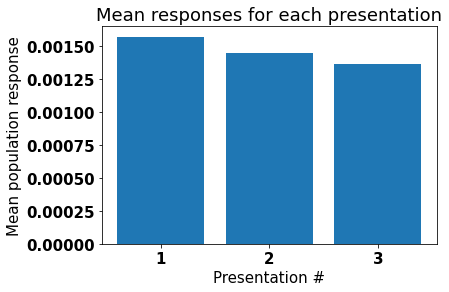

In [87]:
plt.bar([1,2,3],[mean1_sg, mean2_sg, mean3_sg])
plt.title("Mean responses for each presentation")
plt.xticks([1,2,3])
plt.ylabel("Mean population response")
plt.xlabel("Presentation #")
plt.show()

In [122]:
# Fit a linear regression model
slope, intercept, r_value, p_value, std_err = linregress(range(len([mean1_sg, mean2_sg, mean3_sg])), [mean1_sg, mean2_sg, mean3_sg])

# Check if the slope is negative (indicating a decreasing trend) and if the p-value is below a significance level (e.g., 0.05)
if slope < 0 and p_value < 0.05:
    print("The decreasing trend is statistically significant.")
else:
    print(f"The trend is not statistically significant. p-value = {p_value}")

The trend is not statistically significant. p-value = 0.06806896207682832


In [32]:
# Mean responses for each presentation for each stimulus

In [88]:
# Create dataframe with response matrix for each stimulus ID 
sg1_responses_by_stimulus = responses_per_stimulus(sg1, response1_sg)
sg2_responses_by_stimulus = responses_per_stimulus(sg2, response2_sg)
sg3_responses_by_stimulus = responses_per_stimulus(sg3, response3_sg)

# The below only works because the shape of the first dataframe is equal to or larger than the others
sg_responses_by_stimulus = pd.merge(sg1_responses_by_stimulus, sg2_responses_by_stimulus, on="stim_id", how="outer")
sg_responses_by_stimulus = pd.merge(sg_responses_by_stimulus, sg3_responses_by_stimulus, on="stim_id", how="outer")
sg_responses_by_stimulus = sg_responses_by_stimulus.rename(columns={"response_matrix_x": "response_matrix1", "response_matrix_y": "response_matrix2", "response_matrix": "response_matrix3"})

In [89]:
# Calculate mean responses for each stimulus
means_sg = pd.DataFrame(columns=["stim_id", "mean1", "mean2", "mean3"])

index=0
for stim_id in np.unique(sg_responses_by_stimulus.stim_id):
    matrix1 = sg_responses_by_stimulus[sg_responses_by_stimulus.stim_id==stim_id].response_matrix1[index]
    matrix2 = sg_responses_by_stimulus[sg_responses_by_stimulus.stim_id==stim_id].response_matrix2[index]
    matrix3 = sg_responses_by_stimulus[sg_responses_by_stimulus.stim_id==stim_id].response_matrix3[index]

    mean1 = np.nanmean(matrix1)
    mean2 = np.nanmean(matrix2)
    mean3 = np.nanmean(matrix3)

    means_sg.loc[len(means_sg)] = [stim_id, mean1, mean2, mean3]
    index+=1

In [90]:
heatmap_array_sg = list((list(means_sg.mean1), list(means_sg.mean2), list(means_sg.mean3)))
norm_heatmap_array_sg = preprocessing.normalize(heatmap_array_sg)

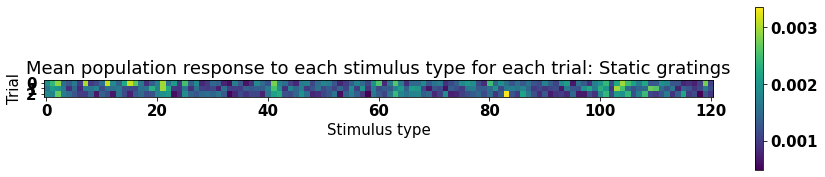

In [91]:
fig, ax = plt.subplots(figsize = (15,3))
im = ax.imshow(heatmap_array_sg)
fig.colorbar(im, ax=ax)
ax.set_yticks([0,1,2])
ax.set_ylabel("Trial")
ax.set_xlabel("Stimulus type")
ax.set_title("Mean population response to each stimulus type for each trial: Static gratings")
plt.show()

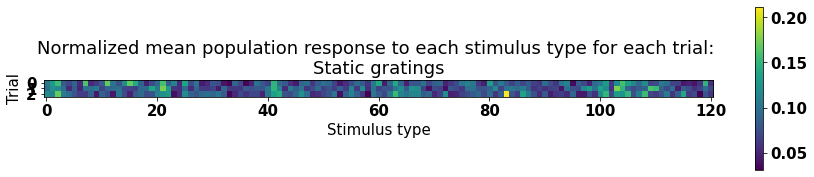

In [92]:
fig, ax = plt.subplots(figsize = (15,3))
im = ax.imshow(norm_heatmap_array_sg)
fig.colorbar(im, ax=ax)
ax.set_yticks([0,1,2])
ax.set_ylabel("Trial")
ax.set_xlabel("Stimulus type")
ax.set_title("Normalized mean population response to each stimulus type for each trial: \nStatic gratings")
plt.show()

In [ ]:
# Natural scenes, session 2 

In [124]:
natural_scenes_table = stim_table[stim_table.stim_category == "natural_scenes"]

In [125]:
divide_indices = find_divide_indices(natural_scenes_table)

In [126]:
ns1, ns2, ns3 = divide_stim_table(natural_scenes_table, divide_indices)

In [127]:
response1_ns = generate_response_matrices(ns1, all_events)
response2_ns = generate_response_matrices(ns2, all_events)
response3_ns = generate_response_matrices(ns3, all_events)

In [128]:
# Calculate mean response

In [129]:
mean1_ns = np.nanmean(response1_ns)
mean2_ns = np.nanmean(response2_ns)
mean3_ns = np.nanmean(response3_ns)

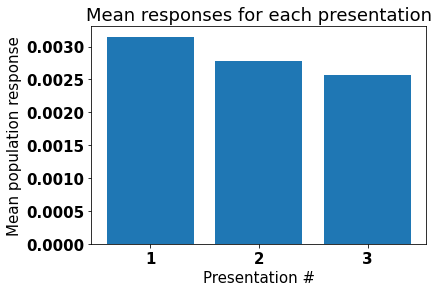

In [130]:
plt.bar([1,2,3],[mean1_ns, mean2_ns, mean3_ns])
plt.title("Mean responses for each presentation")
plt.xticks([1,2,3])
plt.ylabel("Mean population response")
plt.xlabel("Presentation #")
plt.show()

In [131]:
# Fit a linear regression model
slope, intercept, r_value, p_value, std_err = linregress(range(len([mean1_ns, mean2_ns, mean3_ns])), [mean1_ns, mean2_ns, mean3_ns])

# Check if the slope is negative (indicating a decreasing trend) and if the p-value is below a significance level (e.g., 0.05)
if slope < 0 and p_value < 0.05:
    print("The decreasing trend is statistically significant.")
else:
    print(f"The trend is not statistically significant. p-value = {p_value}")

The trend is not statistically significant. p-value = 0.09196792370641176


In [132]:
# Mean responses for each presentation for each stimulus

In [133]:
# Create dataframe with response matrix for each stimulus ID 
ns1_responses_by_stimulus = responses_per_stimulus(ns1, response1_ns)
ns2_responses_by_stimulus = responses_per_stimulus(ns2, response2_ns)
ns3_responses_by_stimulus = responses_per_stimulus(ns3, response3_ns)

# Combine dataframes
ns_responses_by_stimulus = pd.merge(ns1_responses_by_stimulus, ns2_responses_by_stimulus, on="stim_id", how="outer")
ns_responses_by_stimulus = pd.merge(ns_responses_by_stimulus, ns3_responses_by_stimulus, on="stim_id", how="outer")
ns_responses_by_stimulus = ns_responses_by_stimulus.rename(columns={"response_matrix_x": "response_matrix1", "response_matrix_y": "response_matrix2", "response_matrix": "response_matrix3"})

In [135]:
# Calculate mean responses for each stimulus
means_ns = pd.DataFrame(columns=["stim_id", "mean1", "mean2", "mean3"])

index=0
for stim_id in np.unique(ns_responses_by_stimulus.stim_id):
    matrix1 = ns_responses_by_stimulus[ns_responses_by_stimulus.stim_id==stim_id].response_matrix1[index]
    matrix2 = ns_responses_by_stimulus[ns_responses_by_stimulus.stim_id==stim_id].response_matrix2[index]
    matrix3 = ns_responses_by_stimulus[ns_responses_by_stimulus.stim_id==stim_id].response_matrix3[index]

    mean1 = np.nanmean(matrix1)
    mean2 = np.nanmean(matrix2)
    mean3 = np.nanmean(matrix3)

    means_ns.loc[len(means_ns)] = [stim_id, mean1, mean2, mean3]
    index+=1

In [136]:
heatmap_array_ns = np.asarray((list(means_ns.mean1), list(means_ns.mean2), list(means_ns.mean3)))
norm_heatmap_array_ns = preprocessing.normalize(heatmap_array_ns)

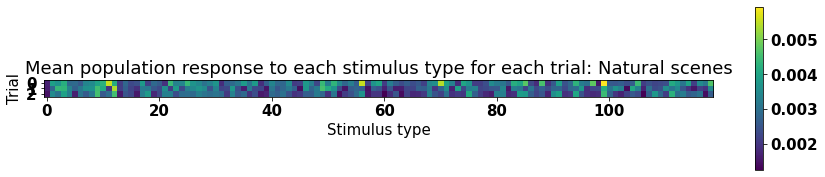

In [137]:
# Plot heat map data
fig, ax = plt.subplots(figsize = (15,3))
im = ax.imshow(heatmap_array_ns)
fig.colorbar(im, ax=ax)
ax.set_yticks([0,1,2])
ax.set_ylabel("Trial")
ax.set_xlabel("Stimulus type")
ax.set_title("Mean population response to each stimulus type for each trial: Natural scenes")
plt.show()


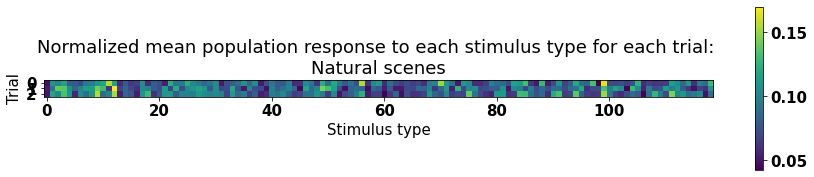

In [138]:
# Plot heat map data
fig, ax = plt.subplots(figsize = (15,3))
im = ax.imshow(norm_heatmap_array_ns)
fig.colorbar(im, ax=ax)
ax.set_yticks([0,1,2])
ax.set_ylabel("Trial")
ax.set_xlabel("Stimulus type")
ax.set_title("Normalized mean population response to each stimulus type for each trial: \nNatural scenes")
plt.show()

In [139]:
np.unique(natural_scenes_table.stim_id)

array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117], dtype=object)

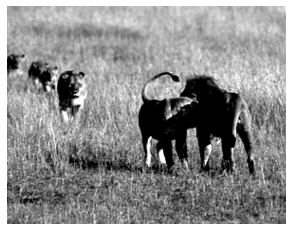

In [123]:
natural_scene_tempate = session_two.get_stimulus_template('natural_scenes')
scene_number=5
plt.imshow(natural_scene_template[scene_number,:,:], cmap='gray')
plt.axis('off');